In [2]:
# Script for vertex fits in Paper
from puma.utils.truth_hadron import ProcessTruthHadrons, AssociateTracksToHadron, SelectHadronMostTracks

#Plotting
from ftag import Cuts, Flavour, Flavours
import matplotlib.pyplot as plt
from puma import Histogram, HistogramPlot

#from puma.hlplots import AuxResults, Tagger
import numpy as np


In [3]:
# basic functions stored in billoir_preprocessing.py file (which is only available in the JAX branch)
from ftag.hdf5 import H5Reader 
import h5py


def ListVariables(file_path):
    with h5py.File(file_path, "r") as f:
        print(f.keys())
        for k in list(f.keys()):
            print(k)
            print(f[k].dtype.fields.keys())

    return



track_var = ["d0", "z0SinTheta", "dphi", "d0Uncertainty", "z0SinThetaUncertainty", "phiUncertainty", "thetaUncertainty", "qOverPUncertainty", "qOverP", "deta", "theta", "dphi"] # for vertex fit
track_var += ["d0RelativeToBeamspot", "d0RelativeToBeamspotUncertainty","z0RelativeToBeamspot", "z0RelativeToBeamspotUncertainty",  "ftagTruthOriginLabel",  "GN2v01_aux_TrackOrigin", "GN2v01_aux_VertexIndex",  "ftagTruthVertexIndex", "ftagTruthParentBarcode"]
track_var += ["JFVertexIndex", "pt"]

jet_var = ["eventNumber","GN2v01_pb", "GN2v01_pc", "GN2v01_pu", "n_tracks", "jetPtRank", "phi", "eta", "HadronConeExclTruthLabelID", "HadronConeExclExtendedTruthLabelID", "HadronConeExclTruthLabelPdgId", "HadronConeExclTruthLabelLxy", "SV1_Lxy", "JetFitterSecondaryVertex_displacement2d", "SV1_L3d", "JetFitterSecondaryVertex_displacement3d", "JetFitter_nVTX", "mcEventWeight", "nPrimaryVertices"] # phi is needed for vertex fit if track phi is not available # v00 instead of v01

jet_var +=['primaryVertexToBeamDisplacementX', 'primaryVertexToBeamDisplacementY', 'primaryVertexToBeamDisplacementZ', 'primaryVertexToTruthVertexDisplacementX', 'primaryVertexToTruthVertexDisplacementY', 'primaryVertexToTruthVertexDisplacementZ', 'truthPrimaryVertexX', 'truthPrimaryVertexY', 'truthPrimaryVertexZ', 'primaryVertexDetectorZ']
jet_var += ['JetFitterSecondaryVertex_nTracks', 'JetFitter_nTracksAtVtx', 'SV1_masssvx', 'JetFitter_mass', 'JetFitterSecondaryVertex_mass']
truth_hadrons = ['pt', 'mass', 'energy', 'eta', 'phi', 'deta', 'dphi', 'dr', 'displacementX', 'displacementY', 'displacementZ','Lxy', 'charge', 'flavour', 'pdgId', 'barcode', 'ftagTruthParentBarcode', 'valid',  'decayVertexDPhi', 'decayVertexDEta'] 



In [4]:
sample = "ttbar"
mc = "MC23a"
directory = "/fs/ddn/sdf/group/atlas/d/lapereir/GN2/OpenDataset_final/"
output = "PaperPlots/"

n_jets = 1000#200000 
n_tracks = 40


path=directory+"/"+mc+"_"+"new-"+sample+".h5"

if sample == "ttbar":
    sample_str = "$t\\overline{t}$"
    cuts = [
        ("pt", ">=", 20000),
        ("pt", "<=", 250000),
        ("eta", ">", -2.5),
        ("eta", "<", 2.5),
        ("HadronConeExclTruthLabelID", ">=", 4), 
        ("HadronConeExclTruthLabelID", "<=", 5),
        ("n_truth_promptLepton", "==", 0)
    ]
    cut_str = "20 < $p_T$ < 250 GeV, $|\\eta| < 2.5$"
        
elif sample == "zprime":
    sample_str = "Z'"
    cuts = [
        ("pt", ">=", 250000),
        ("pt", "<=", 6000000),
        ("eta", ">", -2.5),
        ("eta", "<", 2.5),
        ("HadronConeExclTruthLabelID", ">=", 4), 
        ("HadronConeExclTruthLabelID", "<=", 5),
        ("n_truth_promptLepton", "==", 0)
    ]
    cut_str = "250 < $p_T$ < 6000 GeV, $|\\eta| < 2.5$"


In [5]:
# Explore available variables
ListVariables(path)
#print(path)

# Read dataset
my_reader = H5Reader(path, precision="full", shuffle=False, batch_size=100)
if n_jets == -1:
    dataset = my_reader.load({"jets": jet_var, "tracks" : track_var, "truth_hadrons" : truth_hadrons},  cuts=Cuts.from_list(cuts))
else:
    dataset = my_reader.load({"jets": jet_var, "tracks" : track_var, "truth_hadrons" : truth_hadrons}, num_jets=n_jets, cuts=Cuts.from_list(cuts))


<KeysViewHDF5 ['ConeExclFinalLabels', 'jets', 'tracks', 'truth_hadrons']>
ConeExclFinalLabels
dict_keys(['charge', 'flavour', 'pdgId', 'barcode', 'ftagTruthParentBarcode', 'pt', 'mass', 'energy', 'eta', 'phi', 'deta', 'dphi', 'dr', 'displacementX', 'displacementY', 'displacementZ', 'Lxy', 'decayVertexDPhi', 'decayVertexDEta', 'valid'])
jets
dict_keys(['GN2v01_pb', 'GN2v01_pc', 'GN2v01_pu', 'GN2v01_ptau', 'SV1_correctSignificance3d', 'softMuon_pt', 'softMuon_dR', 'softMuon_eta', 'softMuon_phi', 'softMuon_qOverPratio', 'softMuon_momentumBalanceSignificance', 'softMuon_scatteringNeighbourSignificance', 'softMuon_pTrel', 'softMuon_ip3dD0', 'softMuon_ip3dZ0', 'softMuon_ip3dD0Significance', 'softMuon_ip3dZ0Significance', 'softMuon_ip3dD0Uncertainty', 'softMuon_ip3dZ0Uncertainty', 'JetFitterFlip_energyFraction', 'JetFitterFlip_mass', 'JetFitterFlip_significance3d', 'JetFitterFlip_deltaphi', 'JetFitterFlip_deltaeta', 'JetFitterFlip_massUncorr', 'JetFitterFlip_dRFlightDir', 'pt_btagJes', 'eta_b

In [15]:
#  1) Process Truth Hadron Information (good jets have a clear truth hadron in them)
drop_unrelated_hadrons = True
good_jets, hadron_indices, parent, child, one_hadron, unrelated = ProcessTruthHadrons(dataset, dataset["jets"].shape[0])

# keep only good jets for the remaining studies
jets = dataset["jets"][good_jets]
tracks = dataset["tracks"][good_jets]
truth_hadrons = dataset["truth_hadrons"][good_jets]

#  2) Find index for labeling hadron i.e. parent if there are several truth hadrons
index_lead_hadron = hadron_indices[good_jets][:,0] # hadron indices are  already ordered such that position 0 is the labeling hadron.

# 3) Associate Tracks to Hadron and find index of hadron with most associated tracks
#   ---> index_hadron_most_tracks is the index of the hadron with most tracks. A dummy -99 shows up for jets where all truth hadrons have 0 associated tracks.
#   ---> inclusive_track_vertex is Truth Inclusive SV finding i.e. 1 for tracks from the inclusive SV, 0 otherwise. Shape (n_good_jets, max_n_tracks)
#   ---> exclusive_track_vertex is Truth Exclusive SV finding i.e. 1 for tracks from the inclusive SV, 0 otherwise Shape (n_good_jets, n_truth_hadrons, max_n_tracks)

inclusive_track_vertex, exclusive_track_vertex, index_hadron_most_tracks, n_tracks_inclusive_vertex, n_tracks_exclusive_vertex, vertex_track_mask, good_jet_mask, good_hadron_track_association_mask = AssociateTracksToHadron(dataset, good_jets, drop_bad_jets=True)


# Hadron with most tracks - keep both the hadron variables and the Truth Track to Hadron Association
truth_hadron_most_tracks = SelectHadronMostTracks(truth_hadrons, index_hadron_most_tracks) # you can use it to access truth mass
tracks_from_hadron_most_tracks = SelectHadronMostTracks(exclusive_track_vertex, index_hadron_most_tracks) # Array with booleans (1 indicates track is associated to the vertex)

# Labeling hadron - keep both the hadron variables and the Truth Track to Hadron Association
labeling_truth_hadron = truth_hadrons[np.arange(truth_hadrons.shape[0]),np.array(index_lead_hadron).astype(int)] # you can use it to access truth mass
tracks_from_labeling_truth_hadron = np.array(exclusive_track_vertex[np.arange(exclusive_track_vertex.shape[0]),np.array(index_lead_hadron).astype(int)]) # Array with booleans (1 indicates track is associated to the vertex)


Max number of truth hadrons in your sample:  5
Total number of jets =  1000
 -- Number of jets multiple unrelated hadrons =  24
 -- Number of jets with only 1 SV =  170
 -- Number of jets with a decay chain =  806
   --> # jets with 2 SVs: =  591
   --> # jets with 3+ SVs: =  215
   --> # jets with 4+ SVs: =  10
976  good jets (= the jets with more than one unrelated hadron and light jets with no truth hadrons have been dropped )


(976, 40)
[[3.77777855 3.77777855 3.77777855 ... 3.77777855 3.77777855 3.77777855]
 [1.87502385 1.87502385 1.89048614 ... 1.89048614 1.89048614 1.89048614]
 [1.96393378 1.96393378 1.96393378 ... 1.96393378 1.96393378 1.96393378]
 ...
 [1.62535152 0.13957    1.62535152 ... 0.13957    0.13957    0.13957   ]
 [1.59803788 1.59803788 0.64777811 ... 0.64777811 0.64777811 0.64777811]
 [3.64894851 3.64894851 3.64894851 ... 3.64894851 3.64894851 3.64894851]]
There seems to be an issue with the outgoing calculated mass vertex, it is not the same for each item!
(16592,)
I am using the first index instead, but they should all be unique!


(976,)


/sdf/data/atlas/u/lapereir/FTAG/puma/puma/histogram.py:773: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/sdf/data/atlas/u/lapereir/FTAG/puma/puma/histogram.py:773: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),
/sdf/data/atlas/u/lapereir/FTAG/puma/puma/histogram.py:773: RuntimeWarning: invalid value encountered in subtract
  y1=np.nan_to_num(ratio - ratio_unc, nan=0, posinf=0),


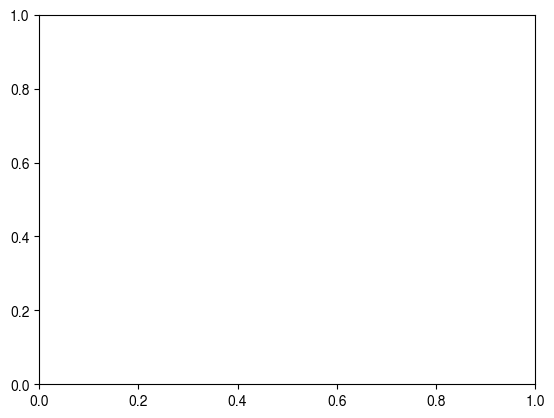

In [34]:
# Mass

# Truth Hadron Mass
###########################################################
mass_labeling_truth_hadron = labeling_truth_hadron["mass"]/1000
mass_truth_hadron_most_tracks = truth_hadron_most_tracks["mass"]/1000
###########################################################


# Calculate Vertex Mass from Track to Hadron Association
###########################################################
from puma.utils.mass import calculate_vertex_mass

# track Eta
jet_eta = np.repeat(jets["eta"], n_tracks).reshape(jets.shape[0], n_tracks) # This is needed because jets have a different format than tracks
track_eta = jet_eta + tracks["deta"] # this is not fully correct


print(tracks_from_labeling_truth_hadron.shape)
# Calculate vertex mass
mass_labeling_vertex = calculate_vertex_mass(tracks["pt"]/1000, track_eta, tracks["dphi"], tracks_from_labeling_truth_hadron)
print(mass_labeling_vertex)

print("There seems to be an issue with the outgoing calculated mass vertex, it is not the same for each item!")
tmp_mass = np.unique(mass_labeling_vertex, axis=1).flatten()
print(tmp_mass.shape) 

print("I am using the first index instead, but they should all be unique!")

#mass_labeling_vertex = np.unique(mass_labeling_vertex, axis=1).flatten()
mass_labeling_vertex = mass_labeling_vertex[:, 0]

mass_vertex_most_tracks = calculate_vertex_mass(tracks["pt"]/1000, track_eta,  tracks["dphi"], tracks_from_hadron_most_tracks)
#mass_vertex_most_tracks =np.unique(mass_vertex_most_tracks, axis=1).flatten()
mass_vertex_most_tracks = mass_vertex_most_tracks[:, 0]

###########################################################


print(mass_labeling_vertex.shape)

hist_label_mass =  Histogram(mass_labeling_truth_hadron[jets["HadronConeExclTruthLabelID"] == 5], label="Labeling Hadron", histtype="step", alpha=1)
hist_most_tracks_mass =  Histogram(mass_truth_hadron_most_tracks[jets["HadronConeExclTruthLabelID"] == 5], label="Hadron with Most Tracks", histtype="step", alpha=1)

hist_label_vertex_mass =  Histogram(mass_labeling_vertex[jets["HadronConeExclTruthLabelID"] == 5], label="Labeling Vertex", histtype="step", alpha=1)
hist_most_tracks_vertex_mass =  Histogram(mass_vertex_most_tracks[jets["HadronConeExclTruthLabelID"] == 5], label="Most Tracks Vertex", histtype="step", alpha=1)

JetFitter_hist = Histogram(jets["JetFitterSecondaryVertex_mass"][jets["HadronConeExclTruthLabelID"] == 5]/1000,label="JetFitter SV", histtype="step", alpha=1) 

com = "13" if "MC20" in mc else "13.6"
plot_histo = HistogramPlot(
    ylabel="Events",
    xlabel="m$_{SV}$ [GeV]",
    logy=False,
    # bins=np.linspace(0, 5, 60),  # you can force a binning for the plot here
    bins=40,  # you can also define an integer number for the number of bins
    bins_range=(0,8),  # only considered if bins is an integer
    norm=False,
    atlas_first_tag="Simulation Internal",
    atlas_second_tag="",
    figsize=(6, 5),
    y_scale=1.7,
    n_ratio_panels=1,
)
    
# Truth

#plot_histo.add(hist_label_mass, reference=False)
#plot_histo.add(hist_most_tracks_mass, reference=False)

# Reco from truth SV finding
plot_histo.add(hist_label_vertex_mass, reference=False)
plot_histo.add(hist_most_tracks_vertex_mass, reference=True)

# Reco from truth algorithms

plot_histo.add(JetFitter_hist, reference = False)

plot_histo.draw()

plot_histo.savefig("./Paper_Histogram_Mass.png", transparent=False)


In [35]:
# Calculate Lxy

Lxy_labeling_truth_hadron = np.sqrt(labeling_truth_hadron["displacementX"]**2, labeling_truth_hadron["displacementY"]**2)

Lxy_truth_hadron_most_tracks = np.sqrt(truth_hadron_most_tracks["displacementX"]**2, truth_hadron_most_tracks["displacementY"]**2)

